# Apache Spark's Structured Streaming

*  Structured Streaming is an extension of the batch processing model that treats data streams as unbounded, continuously appended tables.

* In Structured Streaming, you can think of the streaming data as a table that is continuously updated with new rows as new data arrives. This abstraction makes it easier for developers who are already familiar with batch processing and SQL-like queries to work with streaming data. You can use DataFrame and SQL operations to process and analyze streaming data just as you would with static batch data.

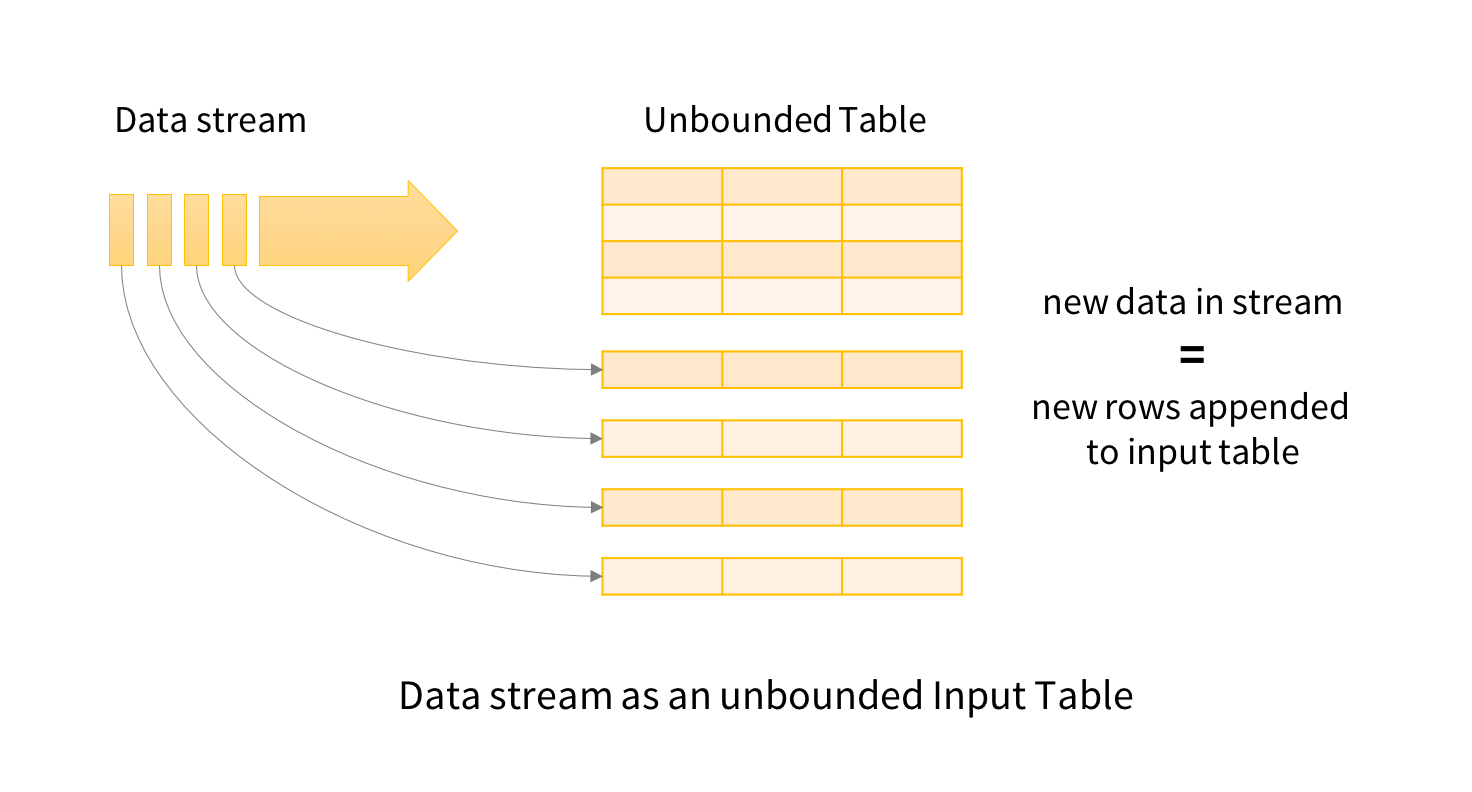

* Each new item in the stream is like a row appended to the input table. We won’t actually retain all the input, but our results will be equivalent to having all of it and running a batch job.

* The developer then defines a query on this input table, as if it were a static table, to compute a final result table that will be written to an output sink.

* Spark automatically converts this batch-like query to a streaming execution plan. This is called incrementalization: Spark figures out what state needs to be maintained to update the result each time a record arrives.

* Finally, developers specify triggers to control when to update the results. Each time a trigger fires, Spark checks for new data (new row in the input table), and incrementally updates the result.

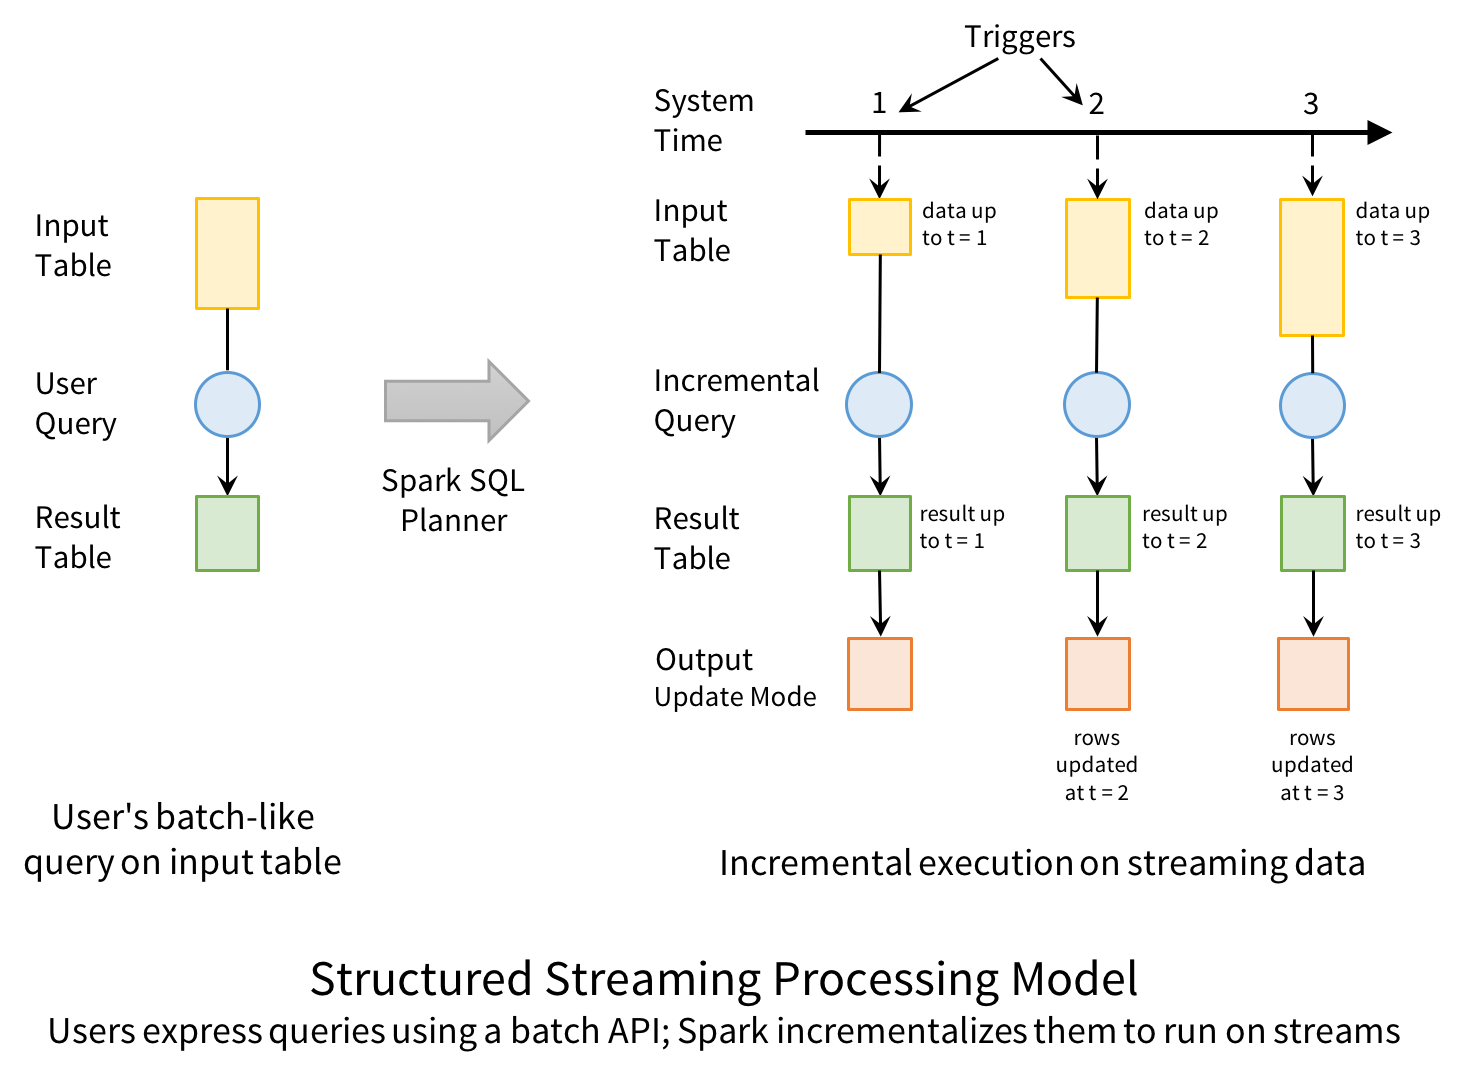

The last part of the model is `output modes`. Each time the result table is updated, the developer wants to write the changes to an external system, such as S3, HDFS, or a database. We usually want to write output incrementally. For this purpose, Structured Streaming provides three output modes:

* `Append`: Only the new rows appended to the result table since the last trigger will be written to the external storage. This is applicable only on queries where existing rows in the result table cannot change (e.g. a map on an input stream).
* `Complete`: The entire updated result table will be written to external storage.
Update: Only the rows that were updated in the result table since the last

* `trigger`: will be changed in the external storage. This mode works for output sinks that can be updated in place, such as a MySQL table.

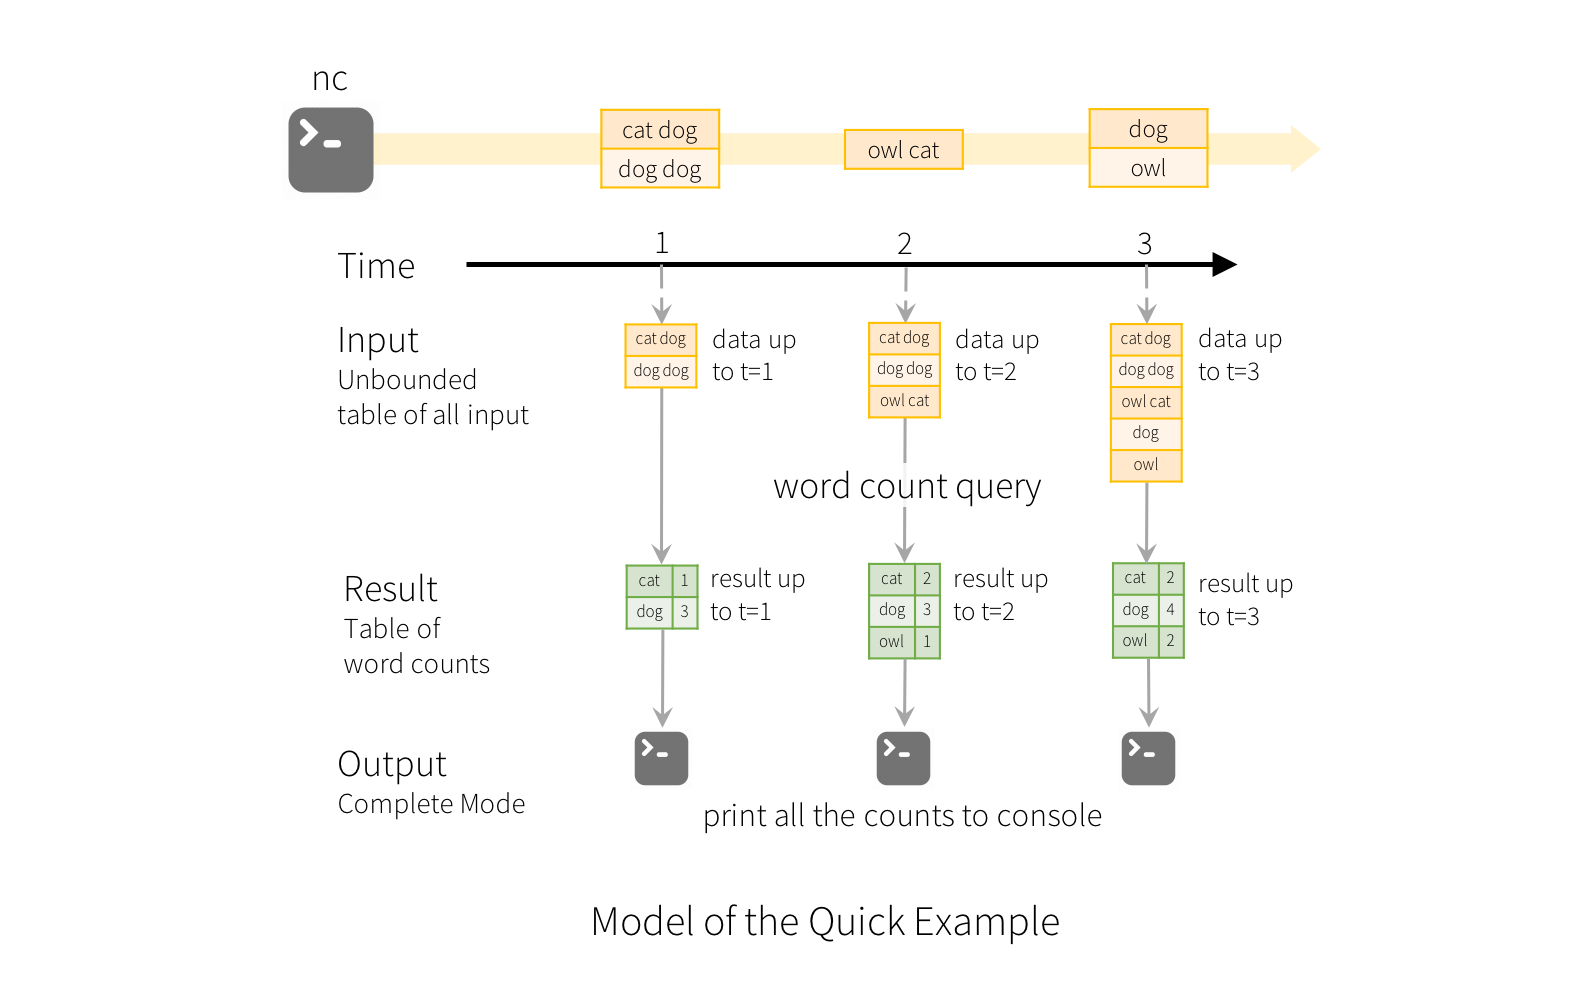

### Import necessary libraries

In [36]:
# Import the findspark library to locate and initialize Spark
import findspark
findspark.init()

# Import necessary components from PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Import necessary classes for defining the schema
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [4]:
# Creating a Spark Session
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Creating a Spark Session
# - 'master' sets the cluster mode to 'local' for local development
# - 'appName' sets a name for the Spark application
# - 'config' is used to configure additional Spark properties, such as the UI port
# - 'getOrCreate' creates a new Spark session or returns an existing one if available
spark = SparkSession.builder.master('local') \
                    .appName('Streaming') \
                    .config('spark.ui.port', '4050') \
                    .getOrCreate()


#### Example 1: read and write from a socket

This example is a simple data streaming pipeline that moves data from the source (socket  on the local machine) to the sink as-is, without modifying or processing the data in any way.

In [ ]:
# Reading Streaming Data from a Socket
# - 'spark.readStream' creates a DataFrame representing a streaming source
# - 'format('socket')' specifies that we're reading from a socket as the streaming source
# - 'option('host', 'localhost')' sets the hostname or IP address of the socket server (typically 'localhost' for local testing)
# - 'option('port', 12345)' specifies the port number on which the socket server is listening
# - 'load()' loads the streaming data source configuration
df = spark.readStream.format('socket') \
    .option('host', 'localhost') \
    .option('port', 12345) \
    .load()


In [ ]:
# Create a DataFrame writer for Structured Streaming
# - 'df.writeStream' sets up the writer for streaming data
# - 'outputMode('append')' specifies the output mode, where only new rows are appended to the console
# - 'format('console')' defines the output format as the console for testing and debugging
writer = df.writeStream.outputMode('append') \
    .format('console')


In [ ]:
# Start the streaming query
query = writer.start()
# Wait for the streaming query to terminate
query.awaitTermination()

In [ ]:
# Wait for the streaming query to terminate
query.awaitTermination()


Write streaming data from a PySpark application using  Netcat server:


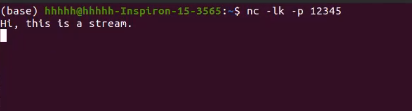

The server terminal:

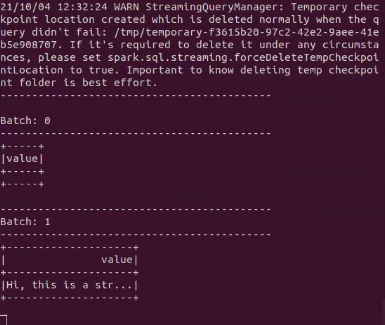

#### Example 2: read data from a socket then split it into lines, flatten the words, and count the occurrence of each word in a streaming data source:


In [5]:
# Define the streaming source (in this case, a socket source)
df_lines = spark.readStream.format('socket') \
    .option('host', 'localhost') \
    .option('port', 12345) \
    .load()

In [6]:
# Split lines into words
df_lines_splitted = df_lines.select(split(col('value'),' ').alias('splitted_df'))

In [7]:
# Flatten the words
df_words = df_lines_splitted.select(explode(col('splitted_df')).alias('words'))

In [8]:
## Group by each word and count occurrences
df_word_count = df_words.groupby('words').count()

In [9]:
# Create a DataFrame writer from df_lines_splitted
writer1 = df_lines_splitted.writeStream.outputMode('append') \
    .format('console')

In [ ]:
# Start the streaming query
query = writer.start()
# Wait for the streaming query to terminate
query.awaitTermination()

In [48]:
#stop query
query.stop()

Write streaming data from a PySpark application using Netcat server:


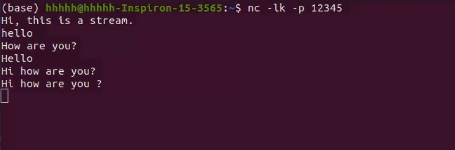

The server terminal:

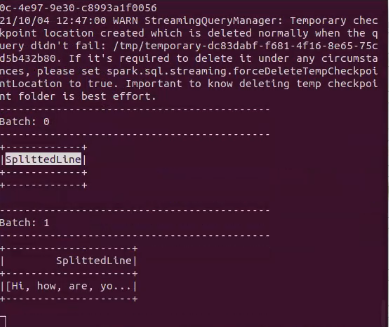



In [10]:
#Create a DataFrame writer from df_words
writer2 = df_words.writeStream.outputMode('append') \
    .format('console')

In [ ]:
# Start the streaming query
query = writer.start()
# Wait for the streaming query to terminate
query.awaitTermination()

In [57]:
#stop query
query.stop()

Write streaming data from a PySpark application using Netcat server:

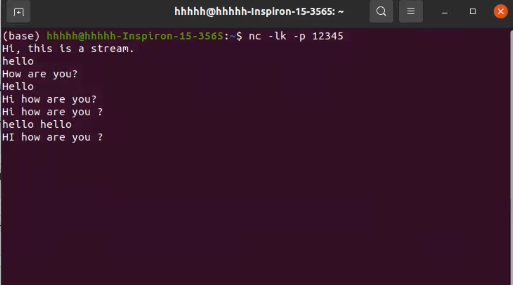

The server terminal:

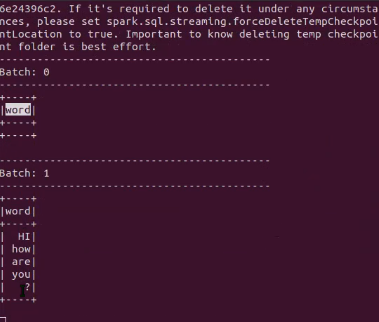

In [ ]:
#Create a DataFrame writer from df_word_count
# - 'option('checkpointLocation','chkpoint_1')' specifies the checkpoint location for fault-tolerance
writer3 = df_word_count.writeStream.outputMode('complete') \
    .format('console')\
    .option('checkpointLocation','chkpoint_1')

In PySpark Structured Streaming, checkpointing is used for fault tolerance and state recovery. While checkpointing is essential for all output modes (append, update, and complete), it's particularly crucial in the "complete" output mode because in "complete" output mode, you typically perform aggregations and transformations that produce the complete result for the entire data stream. This means that the result needs to maintain state information about all the data processed so far, which can be substantial in terms of memory usage.

Write streaming data from a PySpark application using Netcat server:

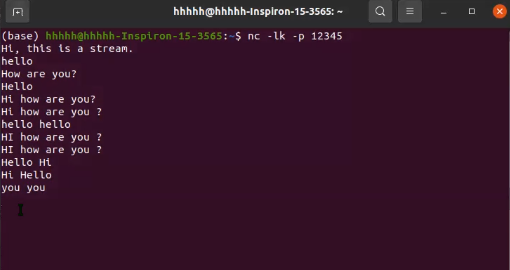

The server terminal:

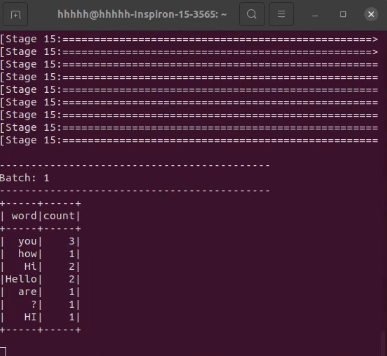

Example 3 : read and write text from folder

In [27]:
# Define the input directory where the text files are located
input_dir = '/content/streaming'

In [28]:
# Read text files from the specified directory
df_text = spark.readStream.format('text')\
.load(input_dir)

In [29]:
# Configure the writer
writer = df_text.writeStream.outputMode('append')\
.format('console')\
.option('truncate',False)\
.option('numRows',15)

In [34]:
# Start the streaming query
query = writer.start()
# Wait for the streaming query to terminate
query.awaitTermination()

The terminal:

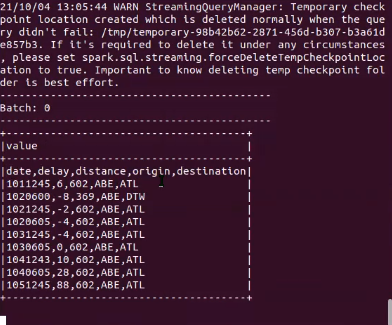

#### Example 4: read streaming data from a CSV file and write the data in a JSON file

In [58]:
# Define the schema for the CSV data
schema = StructType([
    # Define each field in the schema using StructField
    StructField("person_ID", IntegerType(), True),  # IntegerType field for 'person_ID'
    StructField("name", StringType(), True),         # StringType field for 'name'
    StructField("first", StringType(), True),        # StringType field for 'first'
    StructField("last", StringType(), True),         # StringType field for 'last'
    StructField("middle", StringType(), True),       # StringType field for 'middle'
    StructField("email", StringType(), True),        # StringType field for 'email'
    StructField("phone", StringType(), True),        # StringType field for 'phone'
    StructField("fax", StringType(), True),          # StringType field for 'fax'
    StructField("title", StringType(), True)         # StringType field for 'title'
])


In [59]:
# Read csv files from the specified directory
df_csv = spark.readStream.format('csv')\
.schema(schema)\
.option('“header', True)\
.load('/content/streaming')

In [60]:
# Check if the DataFrame df_csv is a streaming DataFrame
print(df_csv.isStreaming)

True


In [63]:
# Select all columns from the DataFrame df_csv and create a new DataFrame results_df
results_df = df_csv.select('*')
# Configure the writer for the streaming DataFrame results_df
query = (results_df.writeStream
.format('json')
.queryName('selectTable')
.option('checkpointLocation', 'checkpoint')
.option('path', 'results')
.outputMode('append')
.start()
.awaitTermination()
)

Two directories have been created: 'results,' which contains the JSON files, and another folder that contains the checkpoints:

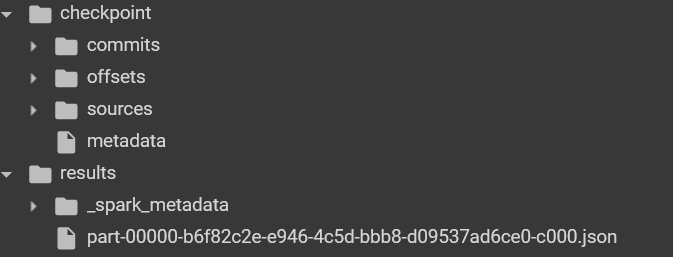